In [1]:
import json
from copy import deepcopy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from datetime import datetime
from tqdm.notebook import tqdm
import os.path
import copy
import seaborn as sns
import lovely_tensors as lt

from utils.others import w, detach_var, rsetattr, rgetattr, count_parameters, print_grads, \
    load_l2o_opter_ckpt, load_baseline_opter_ckpt, load_ckpt
from utils.visualization import get_model_dot
from training import do_fit, fit_normal, fit_optimizer
from regularization import (
    regularize_updates_translation_constraints,
    regularize_updates_scale_constraints,
    regularize_updates_rescale_constraints,
)
from analysis import (
    get_rescale_sym_constraint_deviation,
    get_translation_sym_constraint_deviations,
    get_scale_sym_constraint_deviation,
    get_baseline_opter_param_updates,
    collect_rescale_sym_deviations,
    collect_translation_sym_deviations,
    collect_scale_sym_deviations,
)
from data import MNIST
from optimizer import Optimizer
from optimizee import (
    MNISTNet,
    MNISTNet2Layer,
    MNISTNetBig,
    MNISTRelu,
    MNISTLeakyRelu,
    MNISTSimoidBatchNorm,
    MNISTReluBatchNorm,
)
from meta_module import *

lt.monkey_patch()
sns.set(color_codes=True)
sns.set_style("white")

In [5]:
### load previous checkpoint (and skip meta-training of a new l2O optimizer)
opter, config, ckpt = load_ckpt(dir_path="./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer")
print(json.dumps(config, indent=4, default=str))

{
    "opter_cls": "<class 'optimizer.Optimizer'>",
    "opter_config": {
        "preproc": true,
        "additional_inp_dim": 0,
        "manual_init_output_params": false
    },
    "eval_n_tests": 10,
    "ckpt_base_dir": "./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer",
    "ckpt_baselines_dir": "./ckpt/baselines",
    "meta_training": {
        "data_cls": "<class 'data.MNIST'>",
        "optee_cls": "<class 'optimizee.MNISTReluBatchNorm'>",
        "optee_config": {
            "affine": true,
            "track_running_stats": false
        },
        "n_epochs": 50,
        "n_optim_runs_per_epoch": 20,
        "n_iters": 200,
        "unroll": 20,
        "n_tests": 1,
        "optee_updates_lr": 0.1,
        "opter_lr": 0.01,
        "log_unroll_losses": true,
        "opter_updates_reg_func": "<function regularize_updates_constraints at 0x7fe5478157e0>",
        "reg_mul": 0.001,
        "eval_iter_freq": 10,
        "ckpt_iter_freq": 5,
        "ckpt_dir": "./ckp

# Meta-train a new L2O Optimizer

In [ ]:
### create a new config
config = { # global config
    "opter_cls": Optimizer,
    "opter_config": {
        "preproc": True,
        "additional_inp_dim": 0,
        "manual_init_output_params": False,
    },
    "eval_n_tests": 10,
    "ckpt_base_dir": f"./ckpt/{datetime.now().strftime('%d-%m-%Y_%H-%M-%S')}",
    "ckpt_baselines_dir": "./ckpt/baselines",
}

config["meta_training"] = { # training the optimizer
    "data_cls": MNIST,
    "optee_cls": MNISTReluBatchNorm,
    "optee_config": {"affine": True, "track_running_stats": False},
    "n_epochs": 50,
    "n_optim_runs_per_epoch": 20,
    "n_iters": 200,
    "unroll": 20,
    "n_tests": 1,
    "optee_updates_lr": 0.1,
    "opter_lr": 0.01,
    "log_unroll_losses": True,
    "opter_updates_reg_func": regularize_updates_rescale_constraints,
    "reg_mul": 0.001,
    "eval_iter_freq": 10,
    "ckpt_iter_freq": 5,
    "ckpt_dir": None, # will be set later
}

config["meta_testing"] = { # testing the optimizer
    "data_cls": config["meta_training"]["data_cls"],
    "optee_cls": config["meta_training"]["optee_cls"],
    "optee_config": config["meta_training"]["optee_config"],
    "unroll": 1,
    "n_iters": 500,
    "optee_updates_lr": config["meta_training"]["optee_updates_lr"],
    "train_opter": False,
    "opter_optim": None,
    "ckpt_iter_freq": 5,
    "ckpt_dir": None, # will be set later
}

### additional config
config["ckpt_base_dir"] = f"{config['ckpt_base_dir']}_{config['meta_training']['optee_cls'].__name__}_{config['opter_cls'].__name__}"
# config["ckpt_baselines_dir"] = os.path.join(config["ckpt_base_dir"], "baselines")
config["meta_training"]["ckpt_dir"] = os.path.join(config["ckpt_base_dir"], "meta_training")
config["meta_testing"]["ckpt_dir"] = os.path.join(config["ckpt_base_dir"], "meta_testing")

In [ ]:
### create directories
os.makedirs(config["ckpt_base_dir"], exist_ok=True)
os.makedirs(config["meta_training"]["ckpt_dir"], exist_ok=True)
os.makedirs(config["meta_testing"]["ckpt_dir"], exist_ok=True)
os.makedirs(config["ckpt_baselines_dir"], exist_ok=True)

### dump config
with open(os.path.join(config["ckpt_base_dir"], "config.json"), "w") as f:
    json.dump(config, f, indent=4, default=str)

In [ ]:
### meta-train a new L2O optimizer model
torch.manual_seed(0)
np.random.seed(0)

best_training_loss, metrics, opter_state_dict = fit_optimizer(**config["meta_training"])
opter = w(
    config["opter_cls"](
        **config["opter_config"] if config["opter_config"] is not None else {}
    )
)
opter.load_state_dict(opter_state_dict)
print(best_training_loss)

### save the final model
torch.save({
    "state_dict": opter_state_dict,
    "config": config,
    "loss": best_training_loss,
    "metrics": metrics,
}, os.path.join(config["ckpt_base_dir"], f"l2o_optimizer.pt"))

# Evaluate

In [6]:
optees_to_test = [
    (MNISTNet2Layer, {}),
    (MNISTNetBig, {}),
    (MNISTRelu, {}),
    (MNISTNet, {}),
    (MNISTLeakyRelu, {}),
    (MNISTReluBatchNorm, {"affine": True, "track_running_stats": False}),
]
baselines_to_test_against = [
    ("Adam", optim.Adam, {"lr": 0.03}),
    # ("RMSprop", optim.RMSprop, {"lr": 0.003}),
    ("SGD", optim.SGD, {"lr": 0.1, "momentum": 0.9}),
    # ("NAG", optim.SGD, {"lr": 0.1, "nesterov": True, "momentum": 0.9})
]
use_existing_baselines = True # loads existing if exists, otherwise trains from scratch

## Meta-test L2O optimizer (train optimizee)

In [7]:
### meta-test the L2O optimizer model on various optimizees and compare to baselines
for optee_cls, optee_config in optees_to_test:
    print(f"Testing on {optee_cls.__name__} with config {optee_config}")

    ### set config
    run_config = deepcopy(config)
    run_config["meta_testing"]["optee_cls"] = optee_cls
    run_config["meta_testing"]["optee_config"] = optee_config

    ### train with l2o optimizer
    print("\t Training with L2O optimizer")
    torch.manual_seed(0)
    np.random.seed(0)

    metrics = [
        do_fit(
            opter=opter,
            **run_config["meta_testing"],
        ) for _ in tqdm(range(run_config['eval_n_tests']), "optimizer")
    ]
    # aggregate metrics by metric name and save
    metrics = {k: np.array([m[k] for m in metrics]) for k in metrics[0].keys()}
    metrics_file_name = f"metrics_{optee_cls.__name__}_{optee_config}.npy"
    np.save(os.path.join(run_config["ckpt_base_dir"], metrics_file_name), metrics)
    print(f"\t\t Metrics saved to {os.path.join(run_config['ckpt_base_dir'], metrics_file_name)}")

    ### train with baseline optimizers (or load previous)
    for (opter_name, baseline_opter_cls, extra_kwargs) in baselines_to_test_against:
        print(f"\t Training with {opter_name} optimizer")
        torch.manual_seed(0)
        np.random.seed(0)

        # prepare checkpointing
        baseline_file_nickname = f"{opter_name}_{extra_kwargs}_{run_config['meta_testing']['optee_cls'].__name__}_{run_config['meta_testing']['optee_config']}"
        metrics_file_name = f"metrics_{baseline_file_nickname}.npy"
        ckpt_dir = os.path.join(run_config["ckpt_baselines_dir"], baseline_file_nickname)
        if use_existing_baselines \
            and os.path.exists(ckpt_dir) \
            and os.path.exists(os.path.join(run_config["ckpt_baselines_dir"], metrics_file_name)):
            print(
                f"\t\t Will use existing metrics and checkpoints for {opter_name}, skipping..."
                f"\n\t\t ckpt_dir: {ckpt_dir}"
                f"\n\t\t metrics_file: {os.path.join(run_config['ckpt_baselines_dir'], f'metrics_{ckpt_dir}.npy')}"
            )
            continue

        os.makedirs(ckpt_dir, exist_ok=True)
        
        ### train
        baseline_metrics = fit_normal(
            data_cls=run_config["meta_testing"]["data_cls"],
            optee_cls=run_config["meta_testing"]["optee_cls"],
            optee_config=run_config["meta_testing"]["optee_config"],
            opter_cls=baseline_opter_cls,
            n_iters=run_config["meta_testing"]["n_iters"],
            n_tests=run_config["eval_n_tests"],
            ckpt_iter_freq=run_config["meta_testing"]["ckpt_iter_freq"],
            ckpt_prefix="",
            ckpt_dir=ckpt_dir,
            **extra_kwargs
        )

        ### save metrics to disk
        np.save(os.path.join(run_config["ckpt_baselines_dir"], metrics_file_name), baseline_metrics)
        print(f"\t\t Metrics saved to {os.path.join(run_config['ckpt_baselines_dir'], metrics_file_name)}")


Testing on MNISTNet2Layer with config {}
	 Training with L2O optimizer


optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

		 Metrics saved to ./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer/metrics_MNISTNet2Layer_{}.npy
	 Training with Adam optimizer
		 Will use existing metrics and checkpoints for Adam, skipping...
		 ckpt_dir: ./ckpt/baselines/Adam_{'lr': 0.03}_MNISTNet2Layer_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/Adam_{'lr': 0.03}_MNISTNet2Layer_{}.npy
	 Training with SGD optimizer
		 Will use existing metrics and checkpoints for SGD, skipping...
		 ckpt_dir: ./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet2Layer_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet2Layer_{}.npy
Testing on MNISTNetBig with config {}
	 Training with L2O optimizer


optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

		 Metrics saved to ./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer/metrics_MNISTNetBig_{}.npy
	 Training with Adam optimizer
		 Will use existing metrics and checkpoints for Adam, skipping...
		 ckpt_dir: ./ckpt/baselines/Adam_{'lr': 0.03}_MNISTNetBig_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/Adam_{'lr': 0.03}_MNISTNetBig_{}.npy
	 Training with SGD optimizer
		 Will use existing metrics and checkpoints for SGD, skipping...
		 ckpt_dir: ./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNetBig_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNetBig_{}.npy
Testing on MNISTRelu with config {}
	 Training with L2O optimizer


optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

		 Metrics saved to ./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer/metrics_MNISTRelu_{}.npy
	 Training with Adam optimizer
		 Will use existing metrics and checkpoints for Adam, skipping...
		 ckpt_dir: ./ckpt/baselines/Adam_{'lr': 0.03}_MNISTRelu_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/Adam_{'lr': 0.03}_MNISTRelu_{}.npy
	 Training with SGD optimizer
		 Will use existing metrics and checkpoints for SGD, skipping...
		 ckpt_dir: ./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTRelu_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTRelu_{}.npy
Testing on MNISTNet with config {}
	 Training with L2O optimizer


optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

		 Metrics saved to ./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer/metrics_MNISTNet_{}.npy
	 Training with Adam optimizer
		 Will use existing metrics and checkpoints for Adam, skipping...
		 ckpt_dir: ./ckpt/baselines/Adam_{'lr': 0.03}_MNISTNet_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/Adam_{'lr': 0.03}_MNISTNet_{}.npy
	 Training with SGD optimizer
		 Will use existing metrics and checkpoints for SGD, skipping...
		 ckpt_dir: ./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet_{}.npy
Testing on MNISTLeakyRelu with config {}
	 Training with L2O optimizer


optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

		 Metrics saved to ./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer/metrics_MNISTLeakyRelu_{}.npy
	 Training with Adam optimizer
		 Will use existing metrics and checkpoints for Adam, skipping...
		 ckpt_dir: ./ckpt/baselines/Adam_{'lr': 0.03}_MNISTLeakyRelu_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/Adam_{'lr': 0.03}_MNISTLeakyRelu_{}.npy
	 Training with SGD optimizer
		 Will use existing metrics and checkpoints for SGD, skipping...
		 ckpt_dir: ./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTLeakyRelu_{}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTLeakyRelu_{}.npy
Testing on MNISTReluBatchNorm with config {'affine': True, 'track_running_stats': False}
	 Training with L2O optimizer


optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

		 Metrics saved to ./ckpt/20-02-2023_12-38-02_MNISTReluBatchNorm_Optimizer/metrics_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy
	 Training with Adam optimizer
		 Will use existing metrics and checkpoints for Adam, skipping...
		 ckpt_dir: ./ckpt/baselines/Adam_{'lr': 0.03}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/Adam_{'lr': 0.03}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy
	 Training with SGD optimizer
		 Will use existing metrics and checkpoints for SGD, skipping...
		 ckpt_dir: ./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}
		 metrics_file: ./ckpt/baselines/metrics_./ckpt/baselines/SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy


In [8]:
### load all l2o metrics from disk
l2o_metrics = {}

for metrics_file in [f_name for f_name in os.listdir(config["ckpt_base_dir"]) if f_name.startswith("metrics_")]:
    print(f"Loading {metrics_file}")
    metrics_name = metrics_file[8:-4] # remove the "metrics_" prefix and ".npy" suffix
    l2o_metrics[metrics_name] = np.load(os.path.join(config["ckpt_base_dir"], metrics_file), allow_pickle=True).item()

Loading metrics_MNISTRelu_{}.npy
Loading metrics_MNISTLeakyRelu_{}.npy
Loading metrics_MNISTNetBig_{}.npy
Loading metrics_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy
Loading metrics_MNISTNet2Layer_{}.npy
Loading metrics_MNISTNet_{}.npy


In [9]:
### load baseline metrics from disk
baseline_metrics = dict()

for optee_cls, optee_config in optees_to_test:
    baseline_metrics[f"{optee_cls.__name__}_{optee_config}"] = dict()
    for (opter_name, baseline_opter_cls, extra_kwargs) in baselines_to_test_against:
        metrics_file_name = f"metrics_{opter_name}_{extra_kwargs}_{optee_cls.__name__}_{optee_config}.npy"
        print(f"Loading {metrics_file_name}")
        baseline_metrics[f"{optee_cls.__name__}_{optee_config}"][opter_name] = np.load(os.path.join(config["ckpt_baselines_dir"], metrics_file_name), allow_pickle=True).item()

Loading metrics_Adam_{'lr': 0.03}_MNISTNet2Layer_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet2Layer_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTNetBig_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNetBig_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTRelu_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTRelu_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTNet_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTNet_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTLeakyRelu_{}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTLeakyRelu_{}.npy
Loading metrics_Adam_{'lr': 0.03}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy
Loading metrics_SGD_{'lr': 0.1, 'momentum': 0.9}_MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}.npy


## Plot L2O results alone

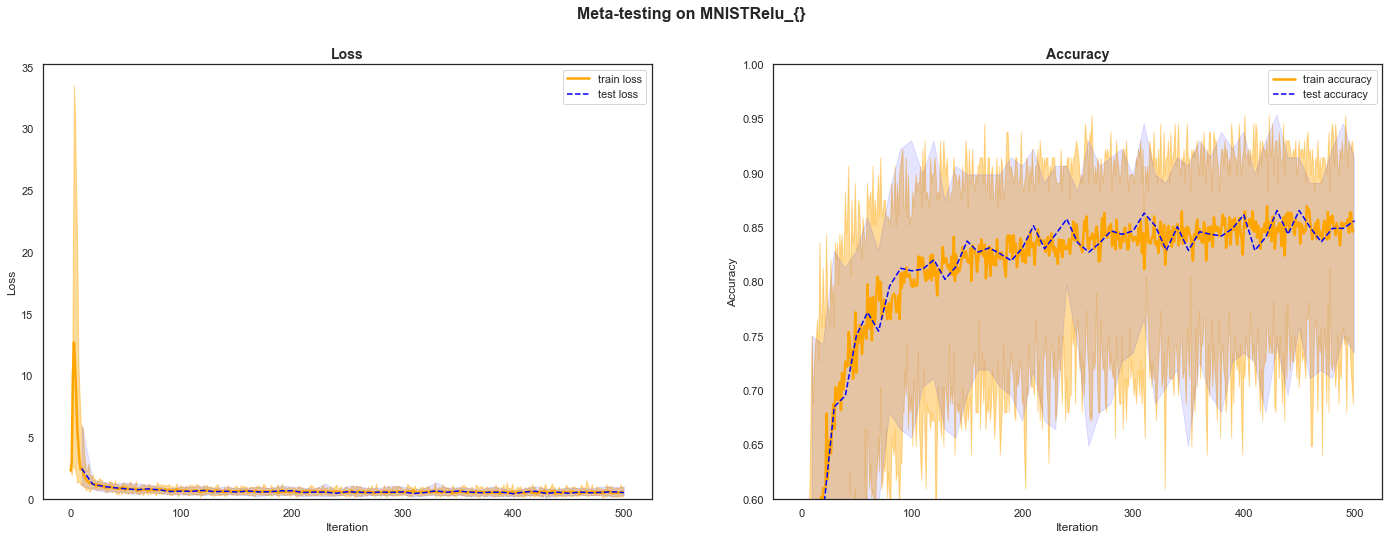

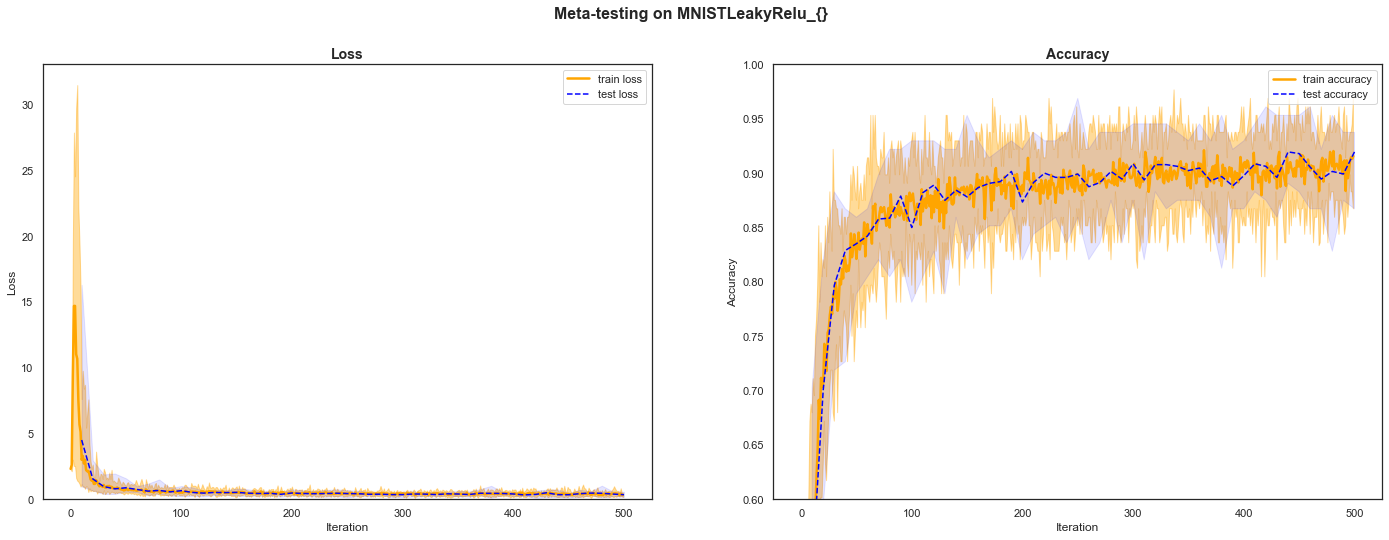

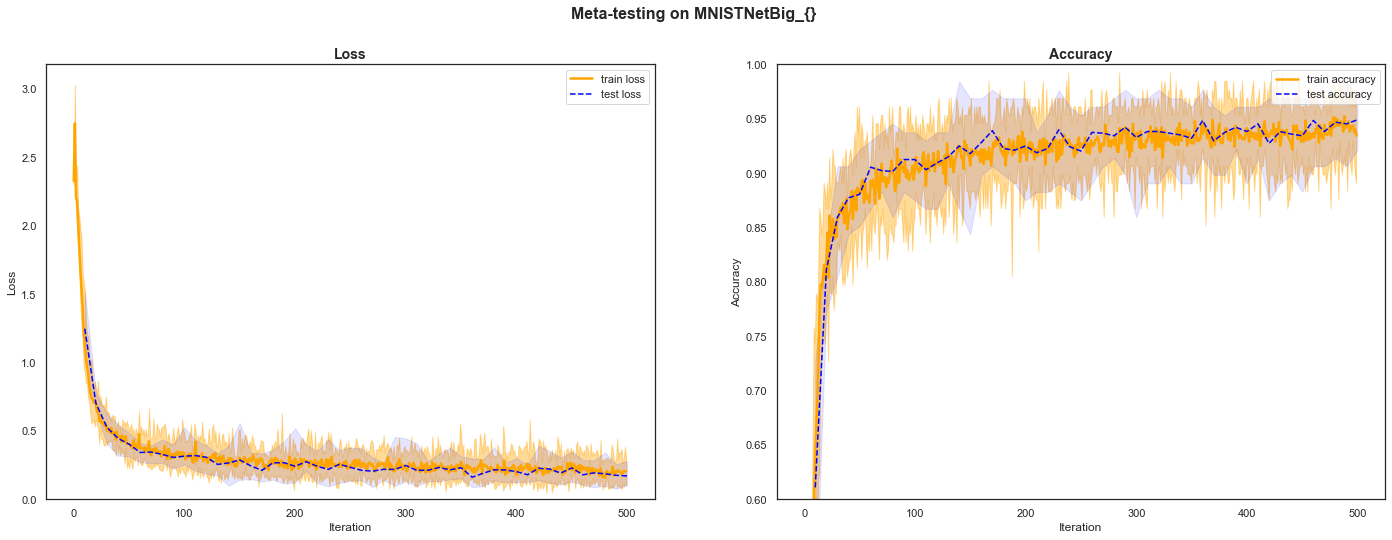

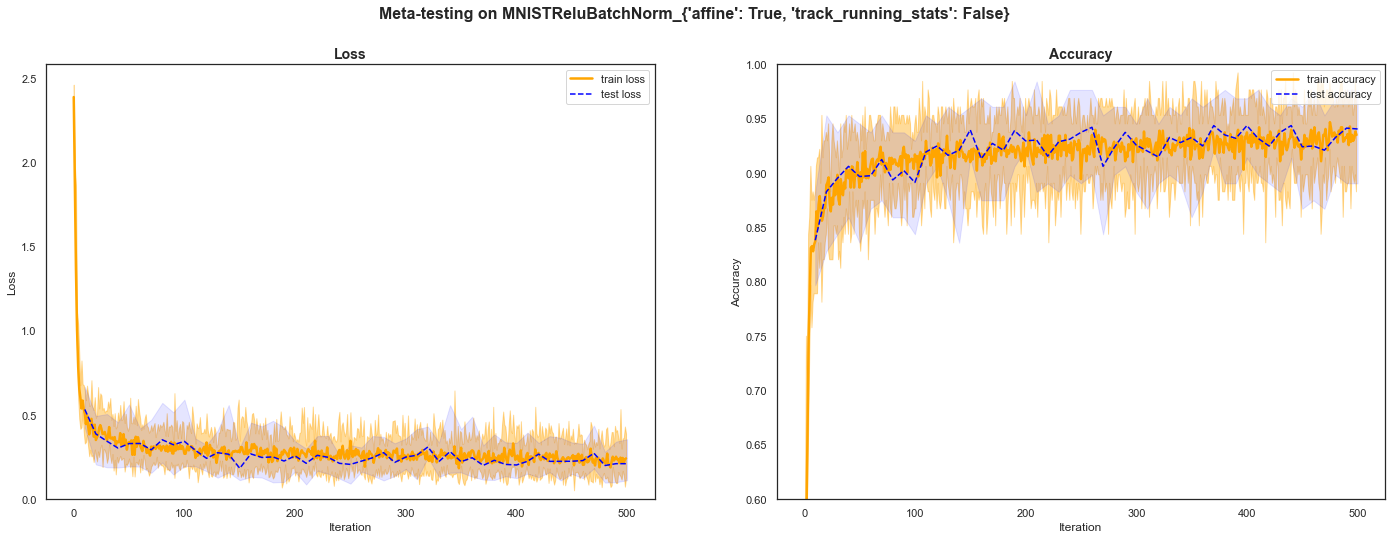

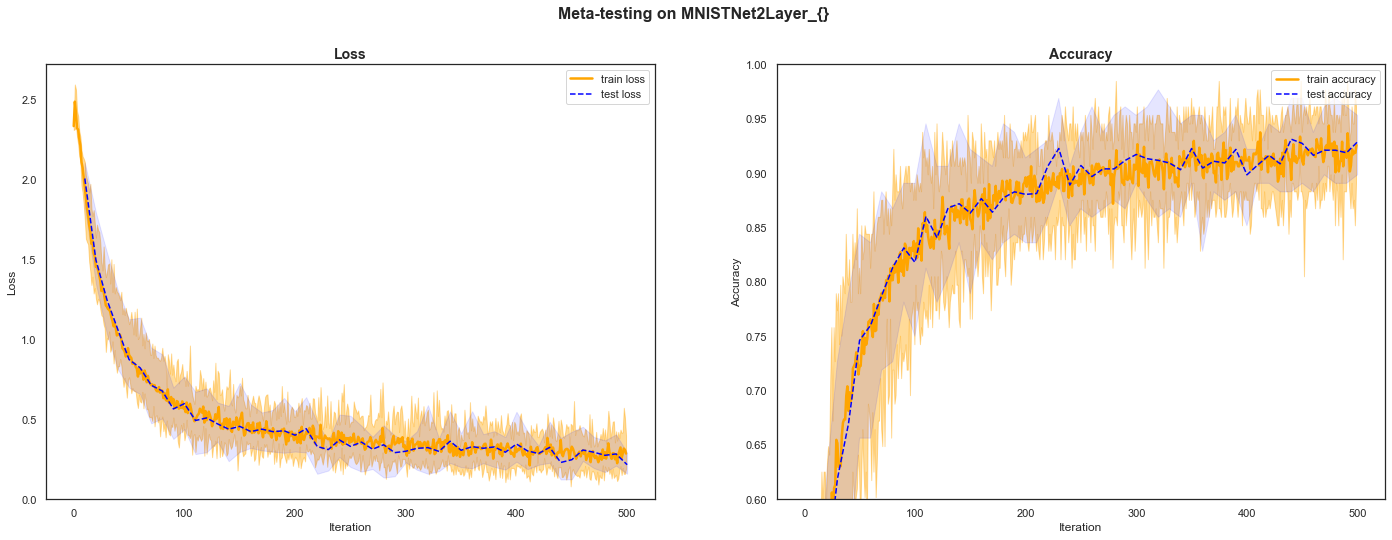

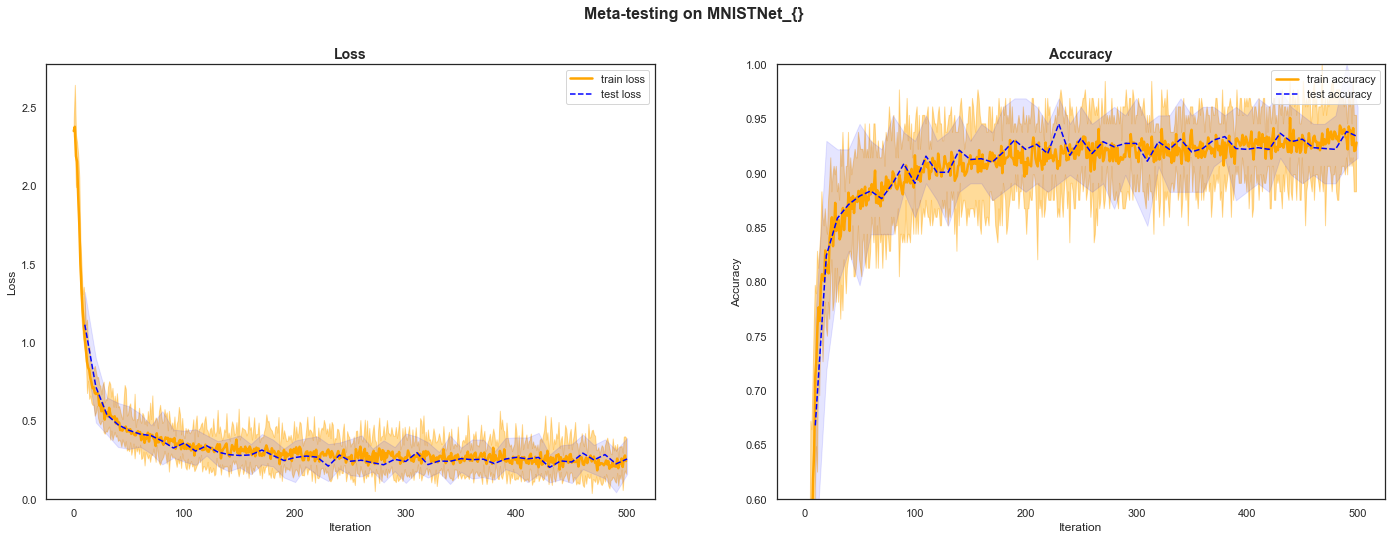

In [10]:
### plot meta-testing results
for optee_nickname, metrics in l2o_metrics.items():
    fig = plt.figure(figsize=(24, 8))
    fig.suptitle(f"Meta-testing on {optee_nickname}", fontsize=16, fontweight="bold")

    ax = fig.add_subplot(121)
    
    ### train loss & test loss
    # train loss
    ax.plot(np.mean(metrics["train_loss"], axis=0), color="orange", linewidth=2.5, label="train loss")
    ax.fill_between(
        x=np.arange(metrics["train_loss"].shape[1]),
        y1=np.min(metrics["train_loss"], axis=0),
        y2=np.max(metrics["train_loss"], axis=0),
        color="orange",
        alpha=0.4,
    )

    # test loss
    x_ticks = np.arange(config["meta_training"]["eval_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_training"]["eval_iter_freq"])
    ax.plot(x_ticks, np.mean(metrics["test_loss"], axis=0), color="blue", linewidth=1.5, linestyle="--", label="test loss")
    ax.fill_between(
        x=x_ticks,
        y1=np.min(metrics["test_loss"], axis=0),
        y2=np.max(metrics["test_loss"], axis=0),
        color="blue",
        alpha=0.1,
    )

    ax.set_title("Loss", fontsize=14, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_ylim(0, None)

    ### train & test accuracy
    # train accuracy
    ax = fig.add_subplot(122)
    ax.plot(np.mean(metrics["train_acc"], axis=0), color="orange", linewidth=2.5, label="train accuracy")
    ax.fill_between(
        x=np.arange(metrics["train_acc"].shape[1]),
        y1=np.min(metrics["train_acc"], axis=0),
        y2=np.max(metrics["train_acc"], axis=0),
        color="orange",
        alpha=0.4,
    )

    # test accuracy
    x_ticks = np.arange(config["meta_training"]["eval_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_training"]["eval_iter_freq"])
    ax.plot(x_ticks, np.mean(metrics["test_acc"], axis=0), color="blue", linewidth=1.5, linestyle="--", label="test accuracy")
    ax.fill_between(
        x=x_ticks,
        y1=np.min(metrics["test_acc"], axis=0),
        y2=np.max(metrics["test_acc"], axis=0),
        color="blue",
        alpha=0.1,
    )

    ax.set_title("Accuracy", fontsize=14, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.set_ylim(0.6, 1)

    plt.show()

    ### save the figure
    fig.savefig(os.path.join(config["ckpt_base_dir"], f"l2o_loss_{optee_nickname}.png"))

## Plot comparison with baseline optimizers (Adam, SGD, RMSprop, ...)

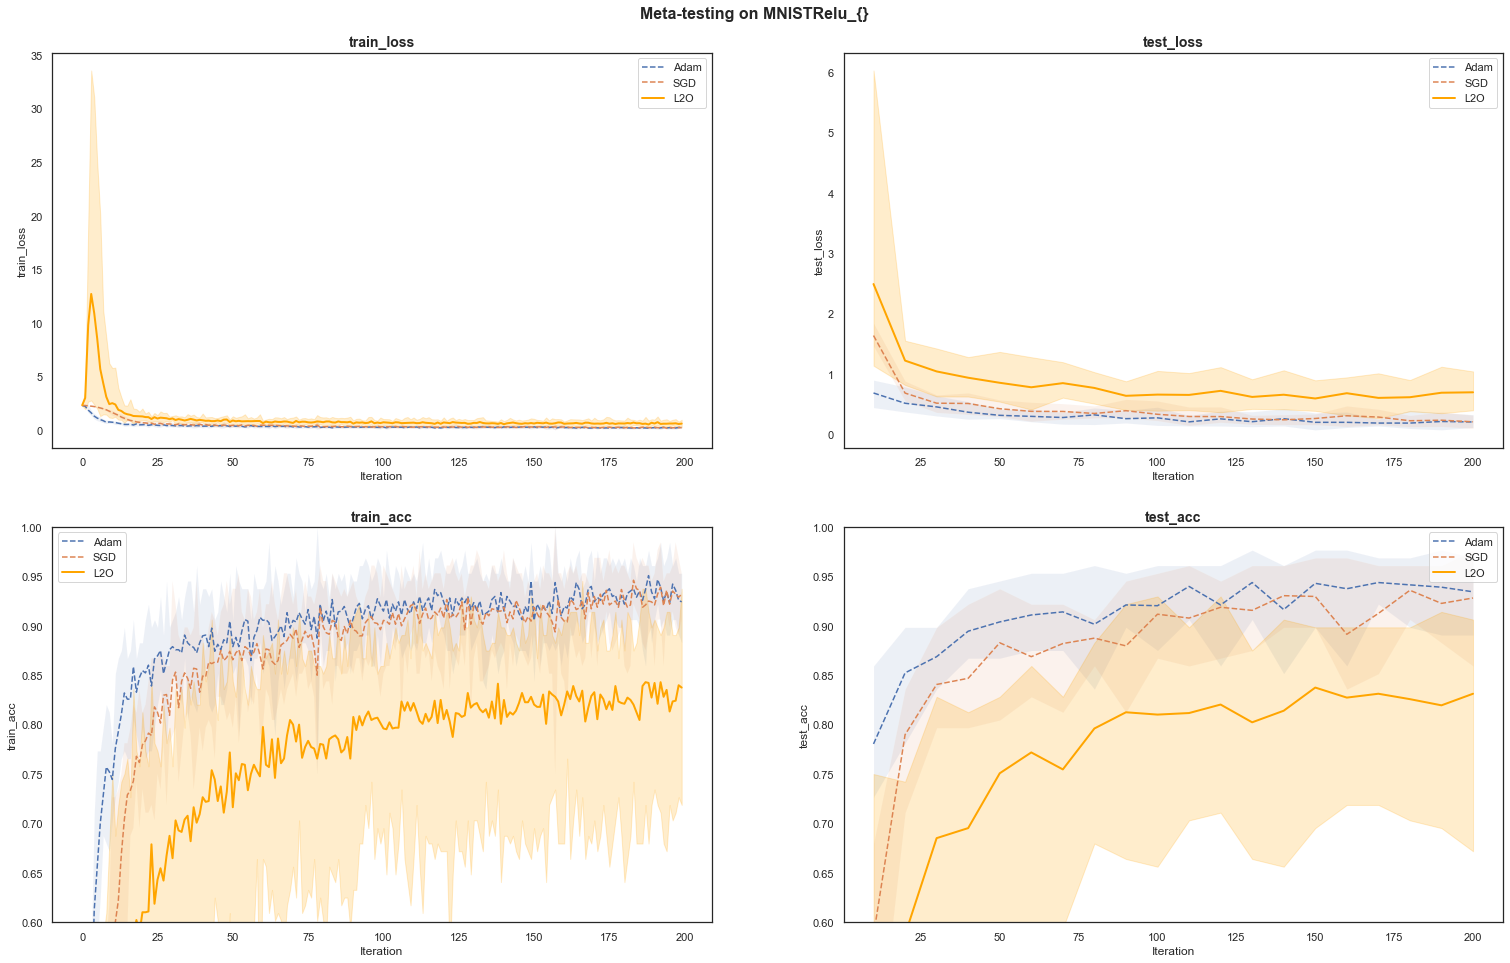

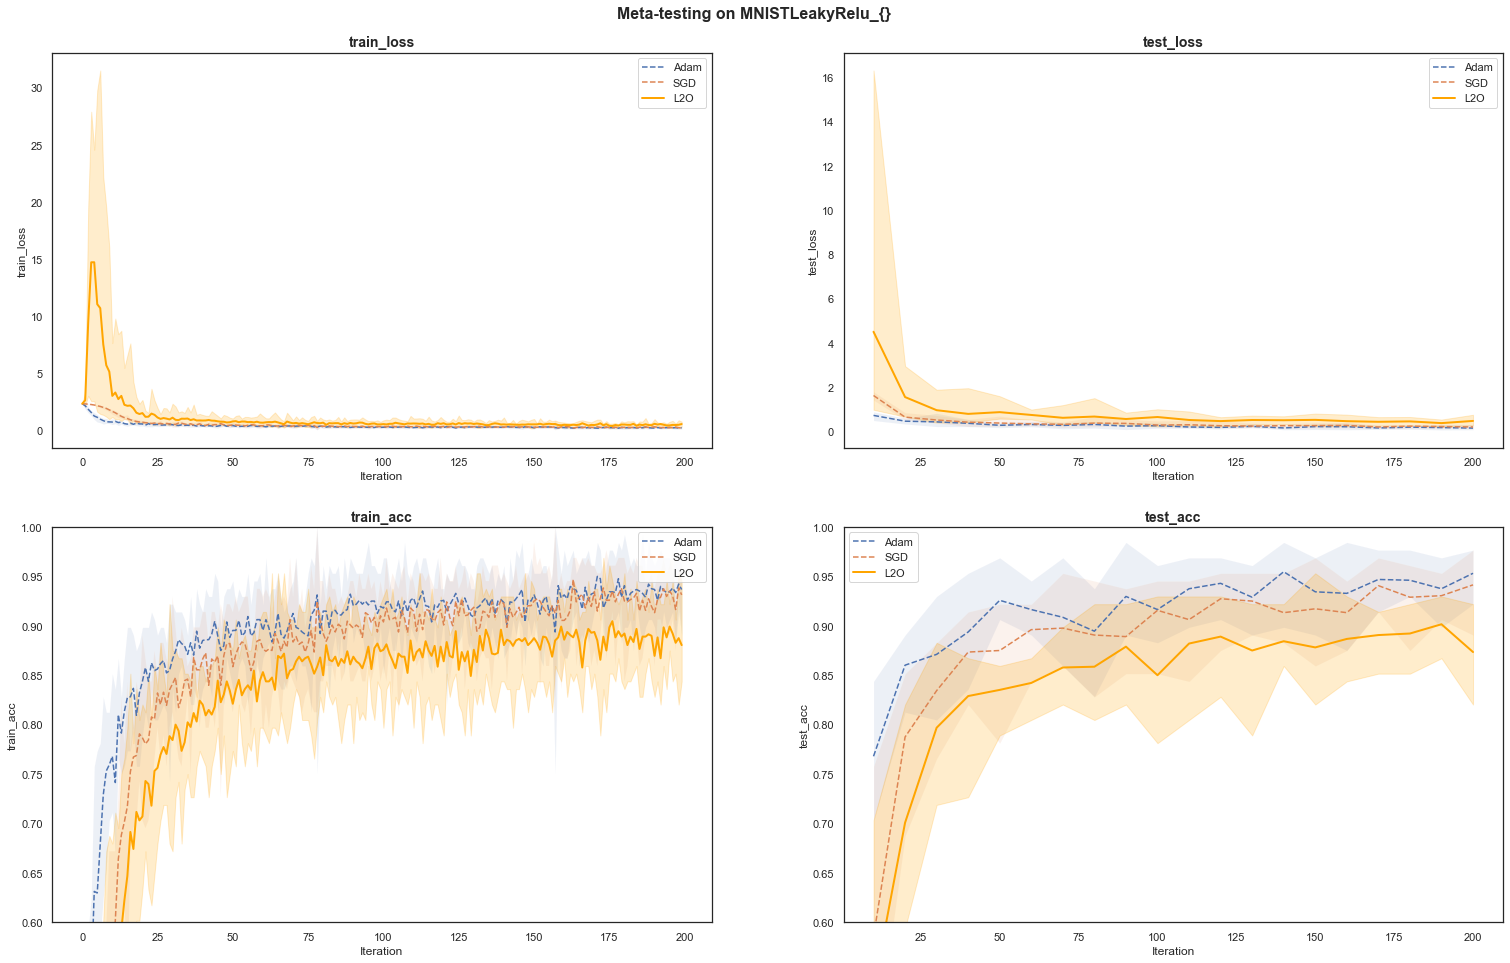

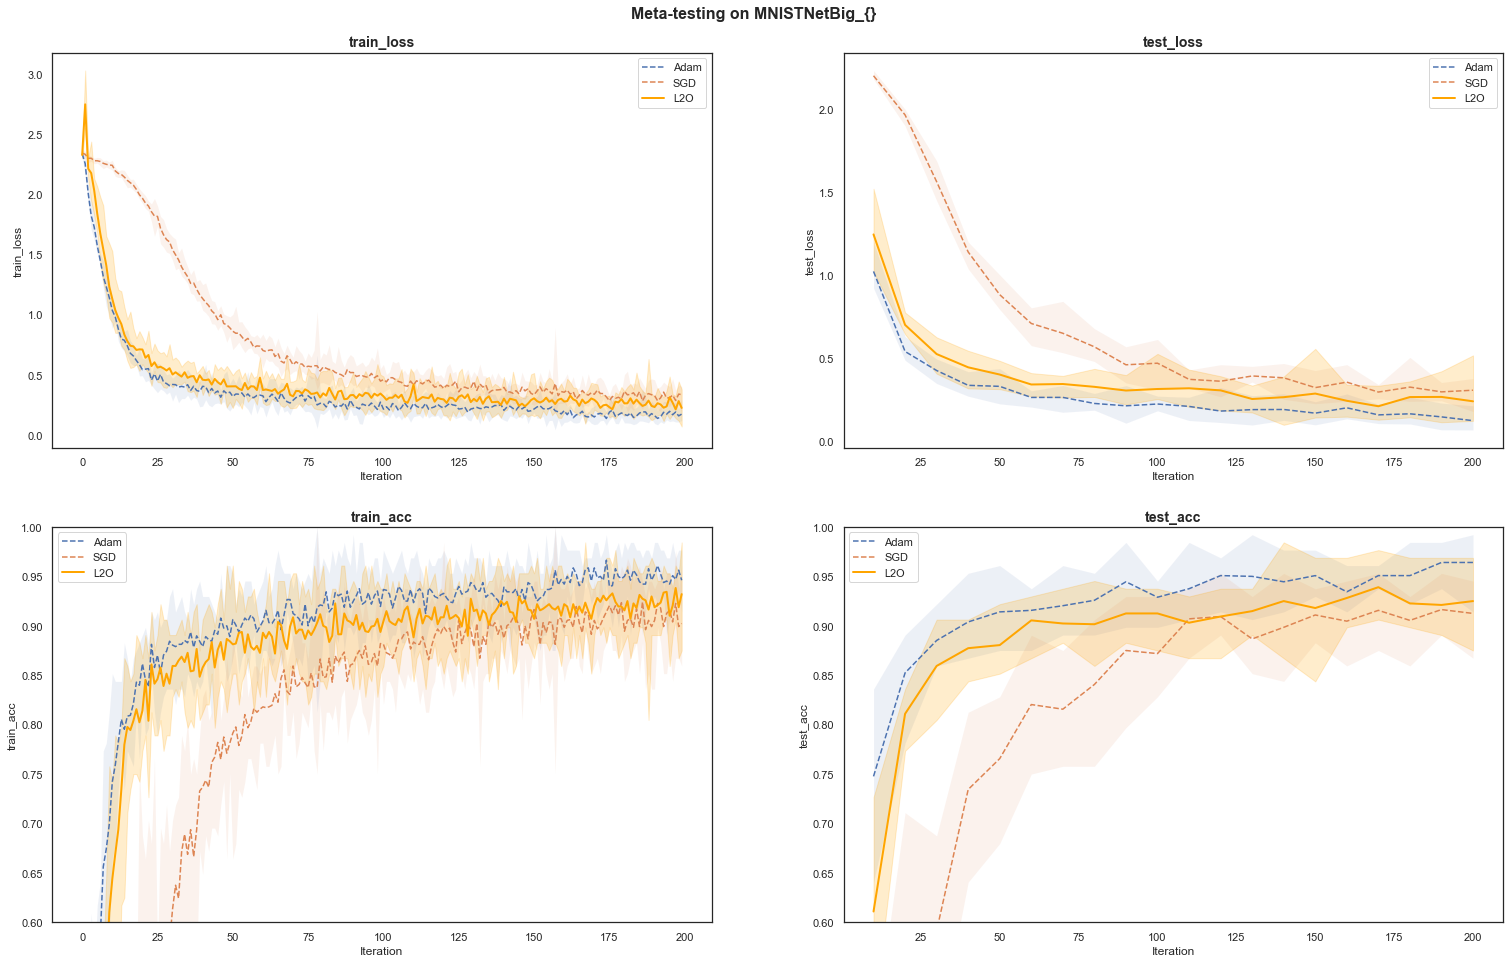

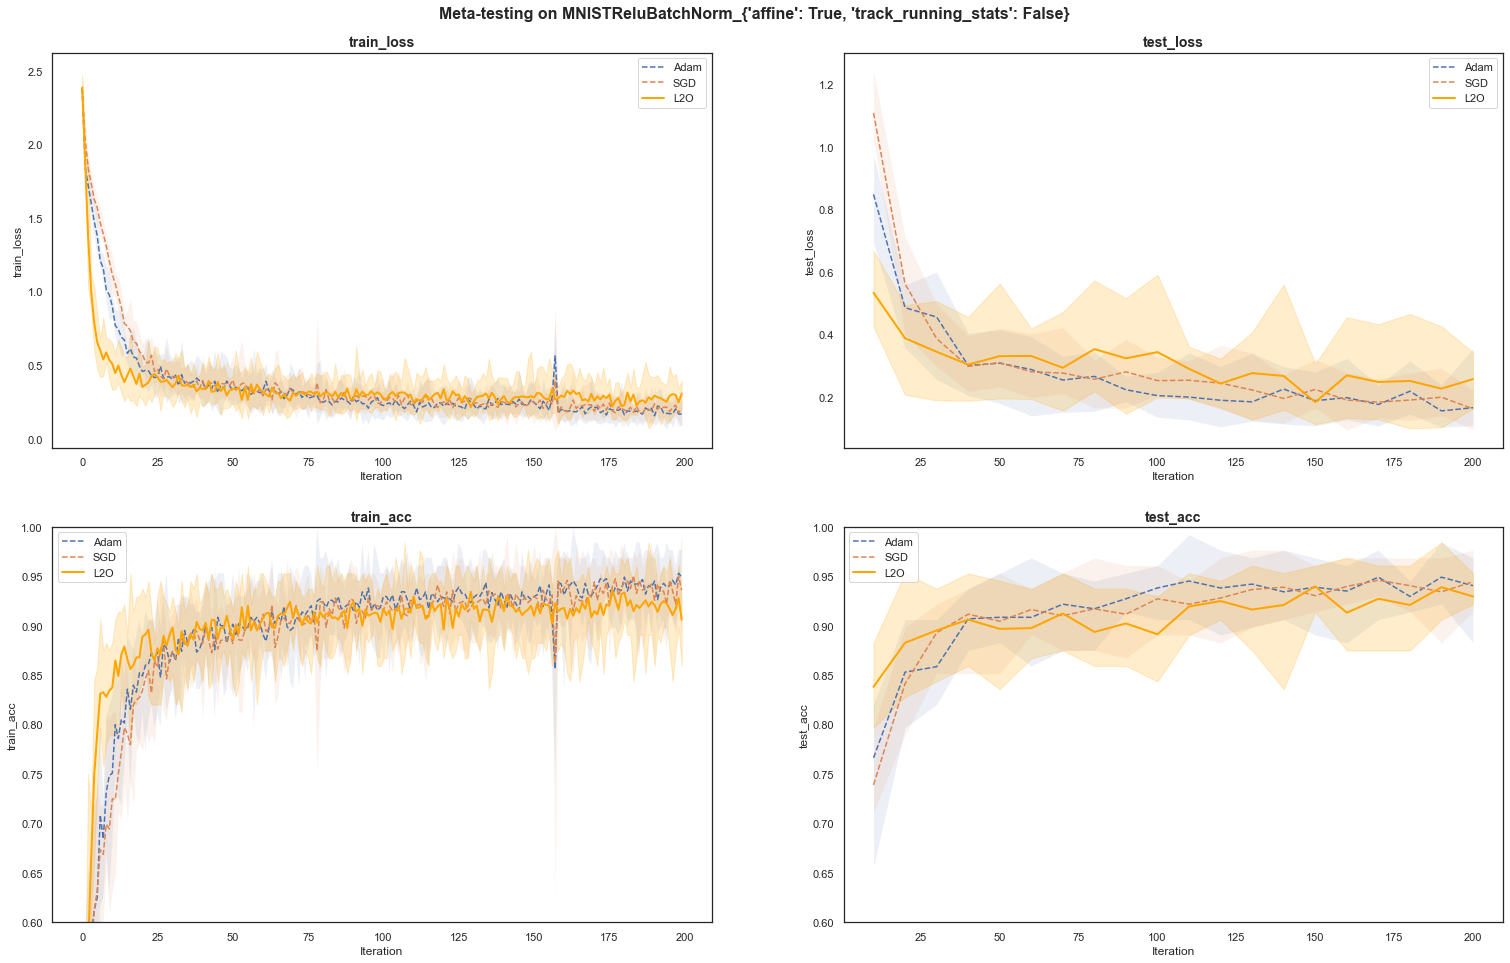

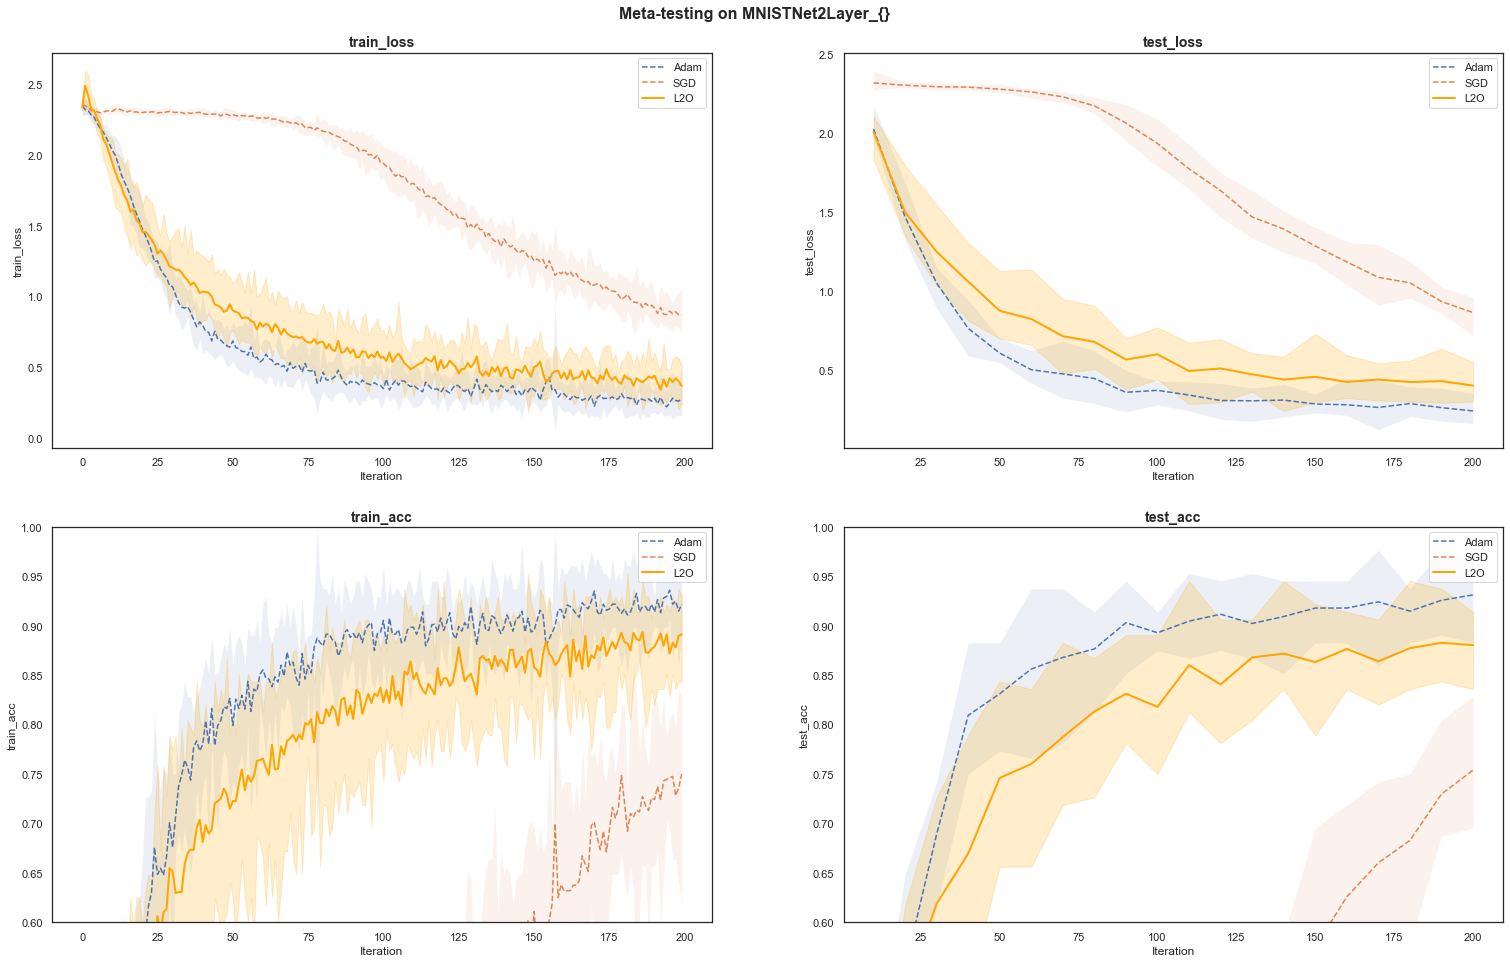

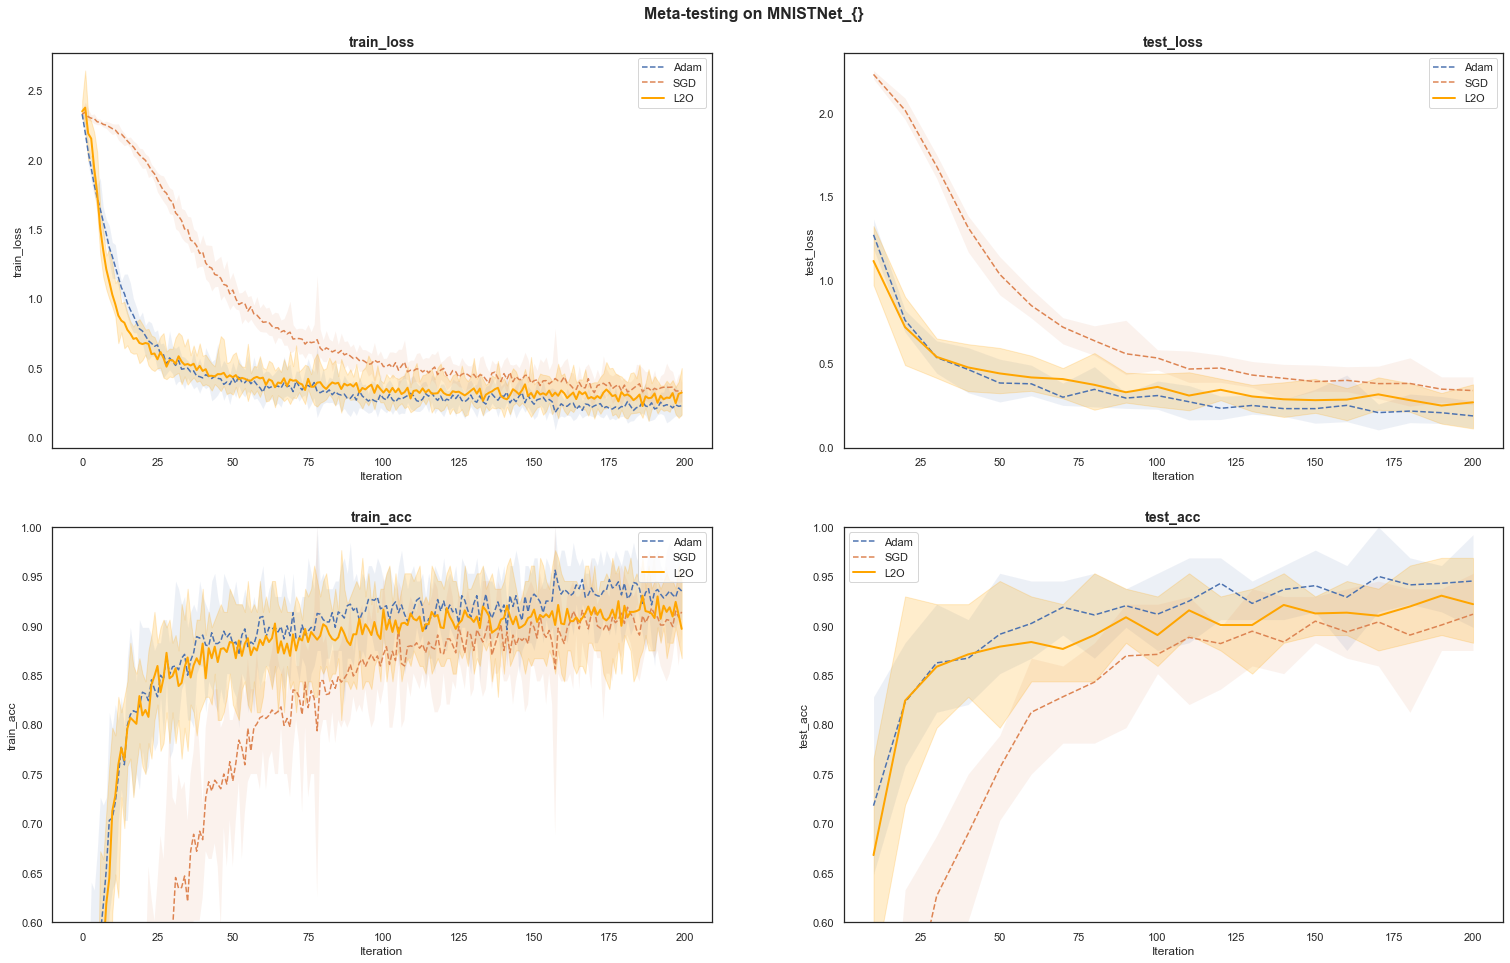

In [11]:
show_max_iters = 200

for optee_nickname, metrics in l2o_metrics.items():
    curr_baseline_metrics = baseline_metrics[optee_nickname]

    ### plot comparison
    fig = plt.figure(figsize=(26, 16))
    fig.suptitle(f"Meta-testing on {optee_nickname}", fontsize=16, fontweight="bold", y=0.92)
    for m_i, metric in enumerate(["train_loss", "test_loss", "train_acc", "test_acc"]):
        ax = fig.add_subplot(2, 2, m_i + 1)
        
        ### baseline optimizers
        for opter_name, opter_metrics in curr_baseline_metrics.items():
            if "test" in metric:
                x = np.arange(config["meta_training"]["eval_iter_freq"], show_max_iters + 1, config["meta_training"]["eval_iter_freq"])
                y = np.mean(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
                y_min = np.min(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
                y_max = np.max(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
            else:
                x = range(opter_metrics[metric][:,:show_max_iters].shape[1])
                y = np.mean(opter_metrics[metric][:,:show_max_iters], axis=0)
                y_min = np.min(opter_metrics[metric][:,:show_max_iters], axis=0)
                y_max = np.max(opter_metrics[metric][:,:show_max_iters], axis=0)
            sns.lineplot(
                x=x,
                y=y,
                label=opter_name,
                linestyle="--",
                ax=ax,
            )
            ax.fill_between(
                x=x,
                y1=y_min,
                y2=y_max,
                alpha=0.1,
            )

            # set y to log scale
            # if "loss" in metric:
            #     ax.set_yscale("log")
        
        ### L2O optimizer
        if "test" in metric:
            x = np.arange(config["meta_training"]["eval_iter_freq"], show_max_iters + 1, config["meta_training"]["eval_iter_freq"])
            y = np.mean(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
            y_min = np.min(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
            y_max = np.max(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
        else:
            x = range(metrics[metric][:,:show_max_iters].shape[1])
            y = np.mean(metrics[metric][:,:show_max_iters], axis=0)
            y_min = np.min(metrics[metric][:,:show_max_iters], axis=0)
            y_max = np.max(metrics[metric][:,:show_max_iters], axis=0)
        sns.lineplot(
            x=x,
            y=y,
            label="L2O",
            color="orange",
            linewidth=2,
            ax=ax,
        )
        ax.fill_between(
            x=x,
            y1=y_min,
            y2=y_max,
            alpha=0.2,
            color="orange",
        )
        
        ### plot settings
        ax.set_title(metric, fontsize=14, fontweight="bold")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(metric)
        if "acc" in metric:
            ax.set_ylim(0.6, 1.0)
        ax.legend()

    plt.show()

    ### save the figure
    fig.savefig(os.path.join(config["ckpt_base_dir"], f"losses_{optee_nickname}.png"))

# Analyze

In [12]:
optee_nickname = f"{config['meta_testing']['optee_cls'].__name__}_{config['meta_testing']['optee_config']}"
print(optee_nickname)

MNISTReluBatchNorm_{'affine': True, 'track_running_stats': False}


## Params, grads, updates

In [13]:
### plot the norm and mean abs value of parameters, gradients, and parameter updates across training
SELECTED_OPTIMIZER = "L2O optimizer" # "L2O optimizer", "SGD", "Adam"

to_plot = {k: {} for k in ["param_norms", "param_abs_means", "grad_norms", "grad_abs_means", "updates_norms", "updates_abs_means"]}
for iter_i in range(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"]):
    if SELECTED_OPTIMIZER == "L2O optimizer":
        # load L2O optimizer
        optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
            path=os.path.join(config["meta_testing"]["ckpt_dir"], f"{iter_i}.pt"),
            optee_cls=config["meta_testing"]["optee_cls"],
            opter_cls=config["opter_cls"],
            optee_config=config["meta_testing"]["optee_config"],
            opter_config=config["opter_config"],
        )
        # scale updates by optee update lr
        optee_updates = {n: p * config["meta_testing"]["optee_updates_lr"] for n, p in optee_updates.items()}
    else:
        # load baseline optimizer
        baseline_opter = [b_opter for b_opter in baselines_to_test_against if b_opter[0] == SELECTED_OPTIMIZER][0]
        baseline_name, baseline_opter_cls, baseline_opter_config = baseline_opter
        baseline_nickname = f"{baseline_name}_{baseline_opter_config}_{optee_nickname}"

        ckpt_dir = os.path.join(config["ckpt_baselines_dir"], baseline_nickname)
        optee, opter, optee_grads, loss_history = load_baseline_opter_ckpt(
            path=os.path.join(ckpt_dir, f"{iter_i}.pt"),
            optee_cls=config["meta_testing"]["optee_cls"],
            opter_cls=baseline_opter[1],
            optee_config=config["meta_testing"]["optee_config"],
            opter_config=baseline_opter[2]
        )
        optee_updates = get_baseline_opter_param_updates(optee, opter)
    for n, p in optee.all_named_parameters():
        for k in to_plot:
            if n not in to_plot[k]:
                to_plot[k][n] = []
        to_plot["param_norms"][n].append(p.norm().item())
        to_plot["param_abs_means"][n].append(p.abs().mean().item())
        to_plot["grad_norms"][n].append(p.grad.norm().item())
        to_plot["grad_abs_means"][n].append(p.grad.abs().mean().item())
        to_plot["updates_norms"][n].append(optee_updates[n].norm().item())
        to_plot["updates_abs_means"][n].append(optee_updates[n].abs().mean().item())

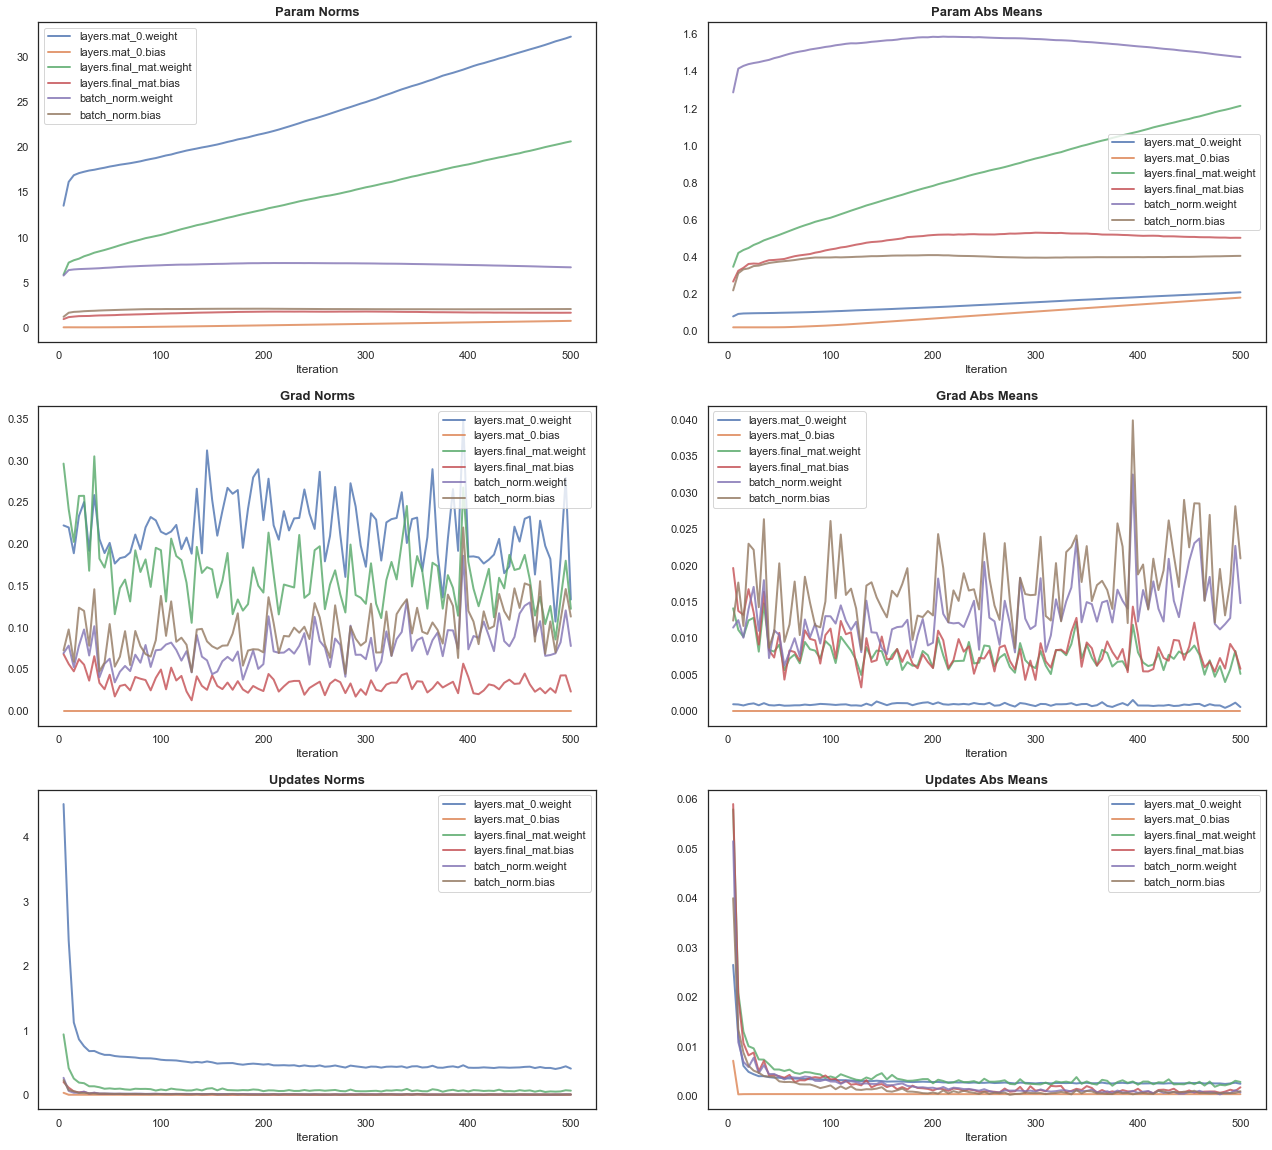

In [14]:
### plot
fig = plt.figure(figsize=(22, 20))
x_ticks = np.arange(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"])

for i, k in enumerate(to_plot.keys()):
    ax = fig.add_subplot(3, 2, i + 1)
    for n in to_plot[k]:
        sns.lineplot(x=x_ticks, y=to_plot[k][n], label=n, alpha=0.8, linewidth=2, ax=ax)
    ax.set_title(k.replace("_", " ").title(), fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.legend()
plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"params_grads_updates_{optee_nickname}.png"))

## Rescale symmetry (ReLU, LeakyReLU, Linear, ...)

### During meta-testing

In [15]:
rescale_sym_grad_deviations = dict()
rescale_sym_update_deviations = dict()

### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
ckpt_path_prefix = os.path.join(config["meta_testing"]["ckpt_dir"], "")
rescale_sym_grad_deviations["L2O Optimizer"], rescale_sym_update_deviations["L2O Optimizer"] = collect_rescale_sym_deviations(
    config=config,
    opter_cls=config["opter_cls"],
    opter_config=config["opter_config"],
    phase="meta_testing",
    ckpt_path_prefix=ckpt_path_prefix,
)

### Baseline optimizers
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
BASELINE_OPTERS_TO_COLLECT_FOR = list(filter(lambda opter: opter[0] in ["Adam", "SGD"], baselines_to_test_against))
for (baseline_name, baseline_opter_cls, baseline_opter_config) in BASELINE_OPTERS_TO_COLLECT_FOR:
    baseline_nickname = f"{baseline_name}_{baseline_opter_config}_{optee_nickname}"
    ckpt_path_prefix = os.path.join(config["ckpt_baselines_dir"], baseline_nickname, "")

    rescale_sym_grad_deviations[baseline_name], rescale_sym_update_deviations[baseline_name] = collect_rescale_sym_deviations(
        config=config,
        opter_cls=baseline_opter_cls,
        opter_config=baseline_opter_config,
        phase="meta_testing",
        ckpt_path_prefix=ckpt_path_prefix,
    )

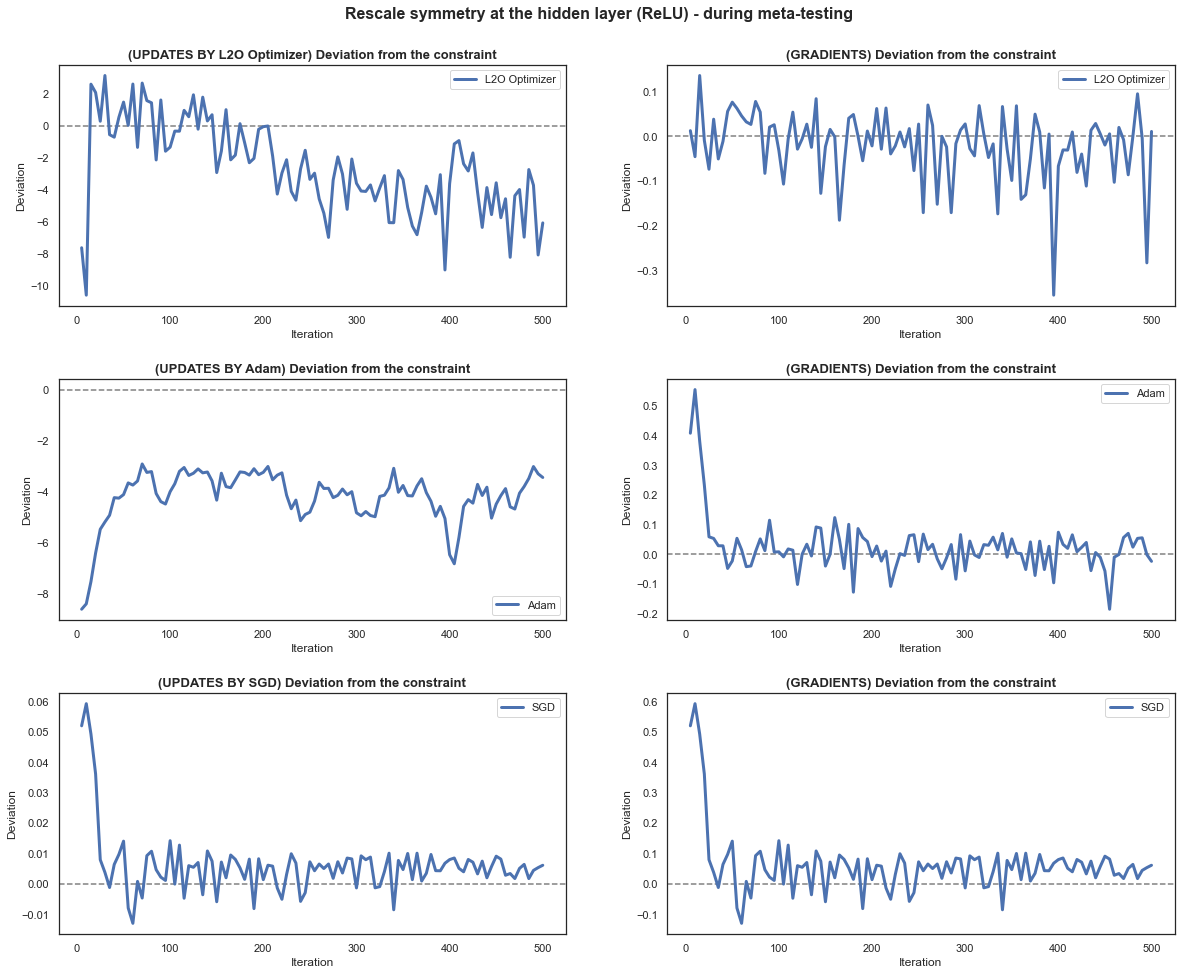

In [16]:
### plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Rescale symmetry at the hidden layer (ReLU) - during meta-testing", fontsize=16, fontweight="bold", y=0.93)
x_ticks = np.arange(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"])

assert rescale_sym_update_deviations.keys() == rescale_sym_grad_deviations.keys()

for opter_i, opter_name in enumerate(rescale_sym_update_deviations.keys()):
    update_deviations = rescale_sym_update_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 1)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=update_deviations, linewidth=3, label=opter_name, ax=ax)
    ax.set_title(f"(UPDATES BY {opter_name}) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # y_lims_first_ax = ax.get_ylim()

    grad_deviations = rescale_sym_grad_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 2)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=grad_deviations, linewidth=3, label=opter_name, ax=ax)
    ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # ax.set_ylim(y_lims_first_ax)

plt.subplots_adjust(hspace=0.3)
plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"rescale_sym_meta_testing_{optee_nickname}.png"))

### During meta-training (only for L2O)

In [17]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
rescale_sym_grad_deviations = dict()
rescale_sym_update_deviations = dict()
for epoch_i in range(0, config["meta_training"]["n_epochs"], 10):
    ckpt_path_prefix = os.path.join(config["meta_training"]["ckpt_dir"], f"{epoch_i}e_")
    rescale_sym_grad_deviations[epoch_i], rescale_sym_update_deviations[epoch_i] = collect_rescale_sym_deviations(
        config=config,
        opter_cls=config["opter_cls"],
        opter_config=config["opter_config"],
        phase="meta_training",
        ckpt_path_prefix=ckpt_path_prefix
    )

assert rescale_sym_update_deviations.keys() == rescale_sym_grad_deviations.keys()

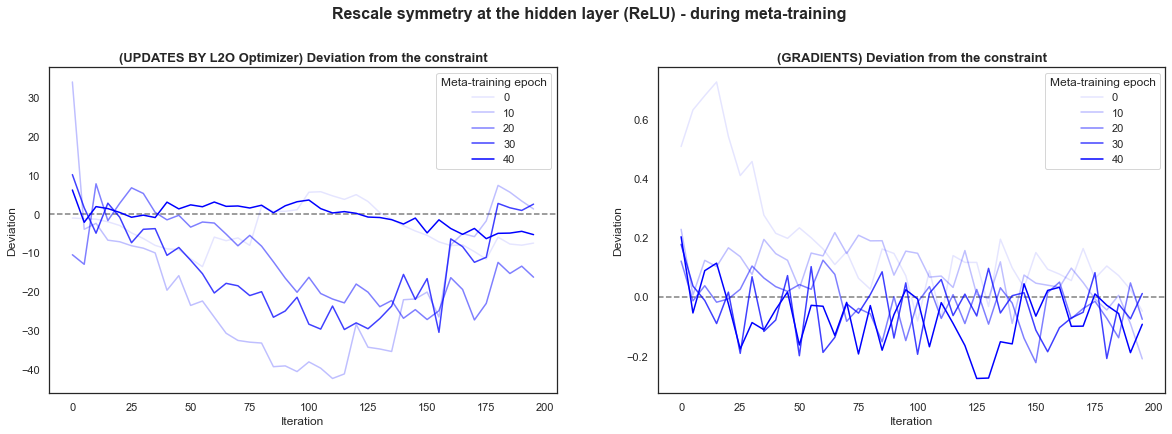

In [18]:
### plot
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Rescale symmetry at the hidden layer (ReLU) - during meta-training", fontsize=16, fontweight="bold", y=1.02)
x_ticks = np.arange(config["meta_training"]["ckpt_iter_freq"], config["meta_training"]["n_iters"] + 1, config["meta_training"]["ckpt_iter_freq"])
x_ticks = np.arange(0, config["meta_training"]["n_iters"], config["meta_training"]["ckpt_iter_freq"])

# L2O updates' deviations
ax = fig.add_subplot(1, 2, 1)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in rescale_sym_update_deviations.keys():
    sns.lineplot(x=x_ticks, y=rescale_sym_update_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(rescale_sym_update_deviations.keys())), color="blue", ax=ax)

ax.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

# true gradient deviations
ax = fig.add_subplot(1, 2, 2)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in rescale_sym_grad_deviations.keys():
    sns.lineplot(x=x_ticks, y=rescale_sym_grad_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(rescale_sym_grad_deviations.keys())), color="blue", ax=ax)

ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"rescale_sym_meta_training_{optee_nickname}.png"))

## Translation symmetry (Softmax)

### During meta-testing

In [19]:
tranlation_sym_grad_deviations = dict()
tranlation_sym_update_deviations = dict()

### L2O optimizer
ckpt_path_prefix = os.path.join(config["meta_testing"]["ckpt_dir"], "")
tranlation_sym_grad_deviations["L2O Optimizer"], tranlation_sym_update_deviations["L2O Optimizer"] = collect_translation_sym_deviations(
    config=config,
    opter_cls=config["opter_cls"],
    opter_config=config["opter_config"],
    phase="meta_testing",
    ckpt_path_prefix=ckpt_path_prefix,
)

### Baseline optimizers
BASELINE_OPTERS_TO_COLLECT_FOR = list(filter(lambda opter: opter[0] in ["Adam", "SGD"], baselines_to_test_against))
for (baseline_name, baseline_opter_cls, baseline_opter_config) in BASELINE_OPTERS_TO_COLLECT_FOR:
    baseline_nickname = f"{baseline_name}_{baseline_opter_config}_{optee_nickname}"
    ckpt_path_prefix = os.path.join(config["ckpt_baselines_dir"], baseline_nickname, "")
    tranlation_sym_grad_deviations[opter_name], tranlation_sym_update_deviations[opter_name] = collect_translation_sym_deviations(
        config=config,
        opter_cls=baseline_opter_cls,
        opter_config=baseline_opter_config,
        phase="meta_testing",
        ckpt_path_prefix=ckpt_path_prefix,
    )

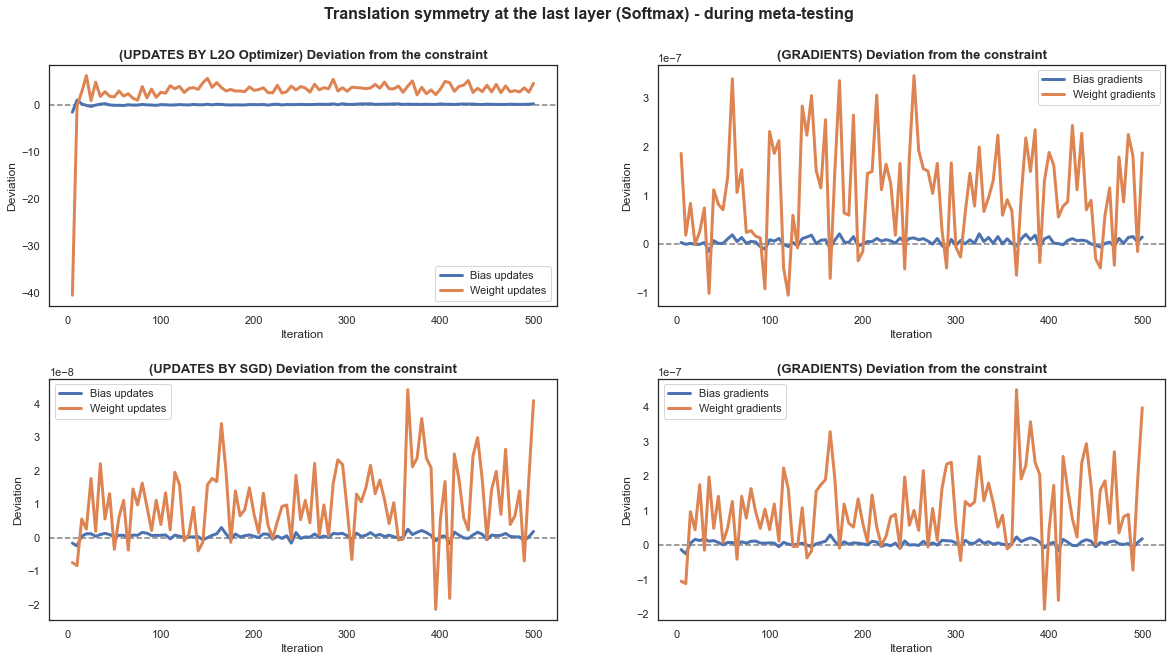

In [20]:
### plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Translation symmetry at the last layer (Softmax) - during meta-testing", fontsize=16, fontweight="bold", y=0.93)
x_ticks = np.arange(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"])

assert tranlation_sym_grad_deviations.keys() == tranlation_sym_update_deviations.keys()

for opter_i, opter_name in enumerate(tranlation_sym_grad_deviations.keys()):
    update_deviations = tranlation_sym_update_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 1)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=update_deviations[:,1], linewidth=3, label=f"Bias updates", ax=ax)
    sns.lineplot(x=x_ticks, y=update_deviations[:,0], linewidth=3, label=f"Weight updates", ax=ax)
    ax.set_title(f"(UPDATES BY {opter_name}) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # y_lims_first_ax = ax.get_ylim()

    grad_deviations = tranlation_sym_grad_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 2)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=grad_deviations[:,1], linewidth=3, label=f"Bias gradients", ax=ax)
    sns.lineplot(x=x_ticks, y=grad_deviations[:,0], linewidth=3, label=f"Weight gradients", ax=ax)
    ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # ax.set_ylim(y_lims_first_ax)

plt.subplots_adjust(hspace=0.3)
plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"translation_sym_meta_testing_{optee_nickname}.png"))

### During meta-training (only for L2O)

In [21]:
### L2O optimizer
tranlation_sym_grad_deviations = dict()
tranlation_sym_update_deviations = dict()
for epoch_i in range(0, config["meta_training"]["n_epochs"], 10):
    ckpt_path_prefix = os.path.join(config["meta_training"]["ckpt_dir"], f"{epoch_i}e_")
    tranlation_sym_grad_deviations[epoch_i], tranlation_sym_update_deviations[epoch_i] = collect_translation_sym_deviations(
        config=config,
        opter_cls=config["opter_cls"],
        opter_config=config["opter_config"],
        phase="meta_training",
        ckpt_path_prefix=ckpt_path_prefix
    )

assert tranlation_sym_grad_deviations.keys() == tranlation_sym_update_deviations.keys()

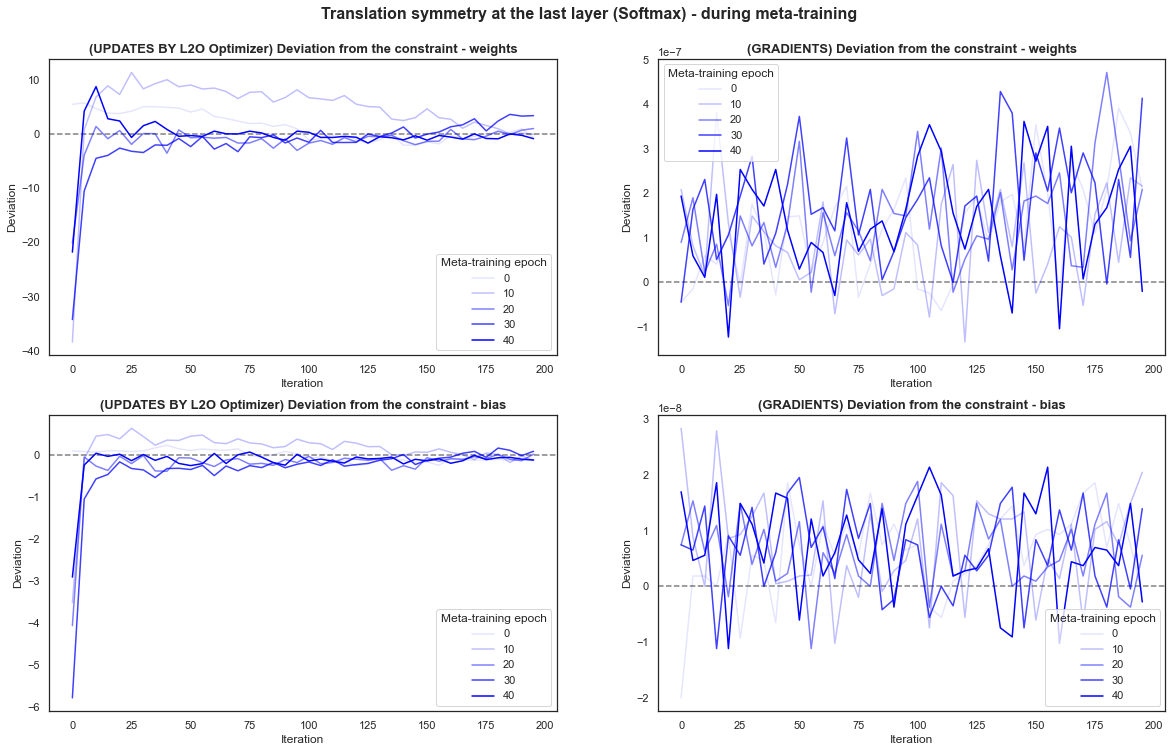

In [22]:
### plot
fig = plt.figure(figsize=(20, 12))
fig.suptitle("Translation symmetry at the last layer (Softmax) - during meta-training", fontsize=16, fontweight="bold", y=0.94)
x_ticks = np.arange(0, config["meta_training"]["n_iters"], config["meta_training"]["ckpt_iter_freq"])

# L2O updates' deviations
ax_W = fig.add_subplot(2, 2, 1)
ax_b = fig.add_subplot(2, 2, 3)
ax_W.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
ax_b.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in tranlation_sym_update_deviations.keys():
    sns.lineplot(x=x_ticks, y=tranlation_sym_update_deviations[epoch_i][:,0], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(tranlation_sym_update_deviations.keys())), color="blue", ax=ax_W)
    sns.lineplot(x=x_ticks, y=tranlation_sym_update_deviations[epoch_i][:,1], linewidth=1.5, label=epoch_i,
        alpha=max(0.1, epoch_i / max(tranlation_sym_update_deviations.keys())), color="blue", ax=ax_b)

ax_W.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint - weights", fontsize=13, fontweight="bold")
ax_b.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint - bias", fontsize=13, fontweight="bold")
ax_W.set_xlabel("Iteration")
ax_b.set_xlabel("Iteration")
ax_W.set_ylabel("Deviation")
ax_b.set_ylabel("Deviation")
ax_W.legend(title="Meta-training epoch")
ax_b.legend(title="Meta-training epoch")

# true gradient deviations
ax_W = fig.add_subplot(2, 2, 2)
ax_b = fig.add_subplot(2, 2, 4)
ax_W.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
ax_b.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in tranlation_sym_grad_deviations.keys():
    sns.lineplot(x=x_ticks, y=tranlation_sym_grad_deviations[epoch_i][:,0], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(tranlation_sym_grad_deviations.keys())), color="blue", ax=ax_W)
    sns.lineplot(x=x_ticks, y=tranlation_sym_grad_deviations[epoch_i][:,1], linewidth=1.5, label=epoch_i,
        alpha=max(0.1, epoch_i / max(tranlation_sym_grad_deviations.keys())), color="blue", ax=ax_b)

ax_W.set_title("(GRADIENTS) Deviation from the constraint - weights", fontsize=13, fontweight="bold")
ax_b.set_title("(GRADIENTS) Deviation from the constraint - bias", fontsize=13, fontweight="bold")
ax_W.set_xlabel("Iteration")
ax_b.set_xlabel("Iteration")
ax_W.set_ylabel("Deviation")
ax_b.set_ylabel("Deviation")
ax_W.legend(title="Meta-training epoch")
ax_b.legend(title="Meta-training epoch")

plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"translation_sym_meta_training_{optee_nickname}.png"))

## Scale symmetry (Batch normalization)

### During meta-testing

In [23]:
scale_sym_grad_deviations = dict()
scale_sym_update_deviations = dict()

### L2O optimizer
ckpt_path_prefix = os.path.join(config["meta_testing"]["ckpt_dir"], "")
scale_sym_grad_deviations["L2O Optimizer"], scale_sym_update_deviations["L2O Optimizer"] = collect_scale_sym_deviations(
    config=config,
    opter_cls=config["opter_cls"],
    opter_config=config["opter_config"],
    phase="meta_testing",
    ckpt_path_prefix=ckpt_path_prefix,
)

### Baseline optimizers
BASELINE_OPTERS_TO_COLLECT_FOR = list(filter(lambda opter: opter[0] in ["Adam", "SGD"], baselines_to_test_against))
for (baseline_name, baseline_opter_cls, baseline_opter_config) in BASELINE_OPTERS_TO_COLLECT_FOR:
    baseline_nickname = f"{baseline_name}_{baseline_opter_config}_{optee_nickname}"
    ckpt_path_prefix = os.path.join(config["ckpt_baselines_dir"], baseline_nickname, "")
    scale_sym_grad_deviations[opter_name], scale_sym_update_deviations[opter_name] = collect_scale_sym_deviations(
        config=config,
        opter_cls=baseline_opter_cls,
        opter_config=baseline_opter_config,
        phase="meta_testing",
        ckpt_path_prefix=ckpt_path_prefix,
    )

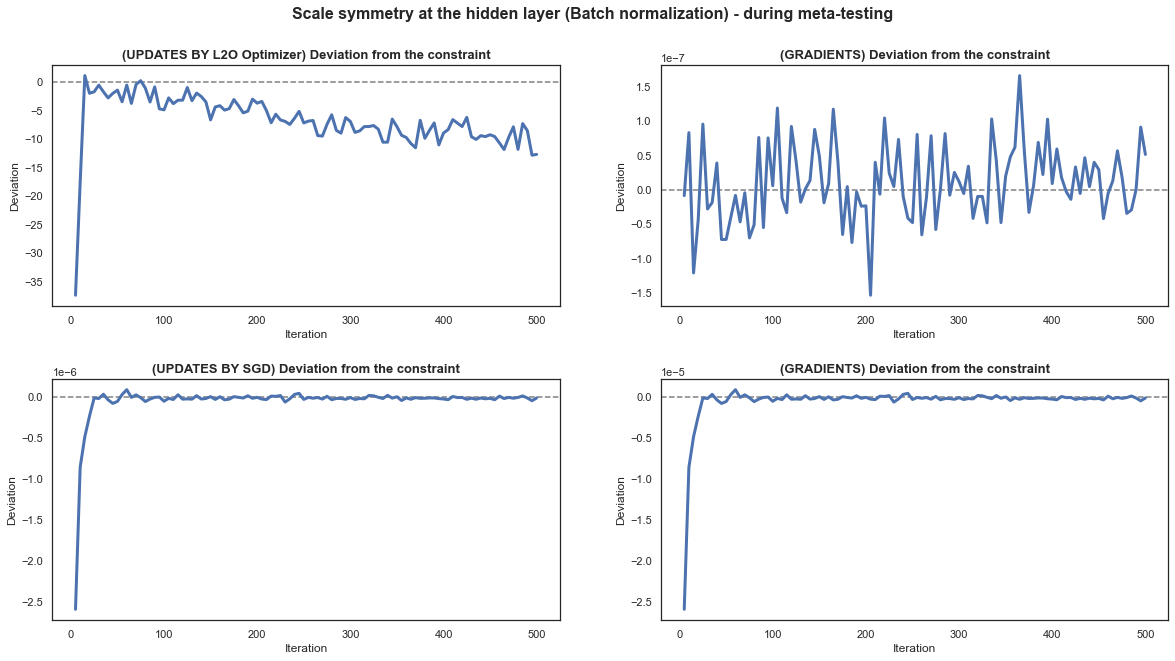

In [24]:
### plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Scale symmetry at the hidden layer (Batch normalization) - during meta-testing", fontsize=16, fontweight="bold", y=0.93)
x_ticks = np.arange(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"])

assert scale_sym_grad_deviations.keys() == scale_sym_update_deviations.keys()

for opter_i, opter_name in enumerate(scale_sym_grad_deviations.keys()):
    update_deviations = scale_sym_update_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 1)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=update_deviations, linewidth=3, ax=ax)
    ax.set_title(f"(UPDATES BY {opter_name}) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    # y_lims_first_ax = ax.get_ylim()

    grad_deviations = scale_sym_grad_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 2)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=grad_deviations, linewidth=3, ax=ax)
    ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    # ax.set_ylim(y_lims_first_ax)

plt.subplots_adjust(hspace=0.3)
plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"scale_sym_meta_testing_{optee_nickname}.png"))

### During meta-training

In [25]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
scale_sym_grad_deviations = dict()
scale_sym_update_deviations = dict()
for epoch_i in range(0, config["meta_training"]["n_epochs"], 10):
    ckpt_path_prefix = os.path.join(config["meta_training"]["ckpt_dir"], f"{epoch_i}e_")
    scale_sym_grad_deviations[epoch_i], scale_sym_update_deviations[epoch_i] = collect_scale_sym_deviations(
        config=config,
        opter_cls=config["opter_cls"],
        opter_config=config["opter_config"],
        phase="meta_training",
        ckpt_path_prefix=ckpt_path_prefix,
    )

assert scale_sym_grad_deviations.keys() == scale_sym_update_deviations.keys()

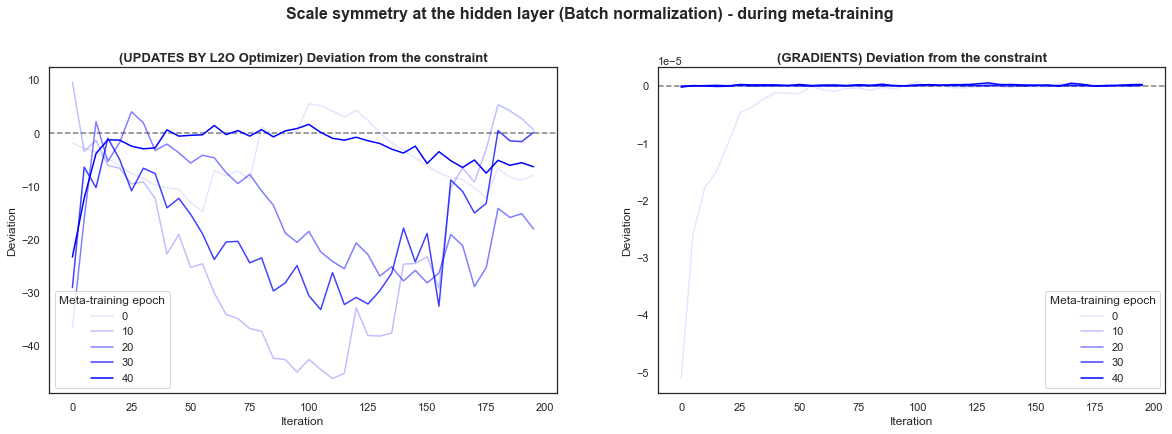

In [26]:
### plot
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Scale symmetry at the hidden layer (Batch normalization) - during meta-training", fontsize=16, fontweight="bold", y=1.02)
x_ticks = np.arange(0, config["meta_training"]["n_iters"], config["meta_training"]["ckpt_iter_freq"])

# L2O updates' deviations
ax = fig.add_subplot(1, 2, 1)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in scale_sym_update_deviations.keys():
    sns.lineplot(x=x_ticks, y=scale_sym_update_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(scale_sym_update_deviations.keys())), color="blue", ax=ax)

ax.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

# true gradient deviations
ax = fig.add_subplot(1, 2, 2)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in scale_sym_grad_deviations.keys():
    sns.lineplot(x=x_ticks, y=scale_sym_grad_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(scale_sym_grad_deviations.keys())), color="blue", ax=ax)

ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

plt.show()

### save the figure
fig.savefig(os.path.join(config["ckpt_base_dir"], f"scale_sym_meta_training_{optee_nickname}.png"))